# Phase 3: Conduct image classification using the neural network approach

In [7]:
import os
import cv2
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import keras
from keras.layers import Input
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

Epoch 1/40 | Train Loss: 2.6703 | Train Acc: 0.1428 | Val Loss: 2.4866 | Val Acc: 0.1953
Epoch 2/40 | Train Loss: 2.5171 | Train Acc: 0.1893 | Val Loss: 2.4502 | Val Acc: 0.2113
Epoch 3/40 | Train Loss: 2.4424 | Train Acc: 0.2108 | Val Loss: 2.4257 | Val Acc: 0.2053
Epoch 4/40 | Train Loss: 2.3767 | Train Acc: 0.2302 | Val Loss: 2.3875 | Val Acc: 0.2300
Epoch 5/40 | Train Loss: 2.3321 | Train Acc: 0.2470 | Val Loss: 2.4010 | Val Acc: 0.2220
Epoch 6/40 | Train Loss: 2.2907 | Train Acc: 0.2625 | Val Loss: 2.3955 | Val Acc: 0.2247
Epoch 7/40 | Train Loss: 2.2632 | Train Acc: 0.2742 | Val Loss: 2.4222 | Val Acc: 0.2207
Epoch 8/40 | Train Loss: 2.2090 | Train Acc: 0.2832 | Val Loss: 2.3709 | Val Acc: 0.2327
Epoch 9/40 | Train Loss: 2.1780 | Train Acc: 0.2945 | Val Loss: 2.3972 | Val Acc: 0.2347
Epoch 10/40 | Train Loss: 2.1361 | Train Acc: 0.3127 | Val Loss: 2.3874 | Val Acc: 0.2453
Epoch 11/40 | Train Loss: 2.1124 | Train Acc: 0.3257 | Val Loss: 2.3984 | Val Acc: 0.2327
Epoch 12/40 | Train

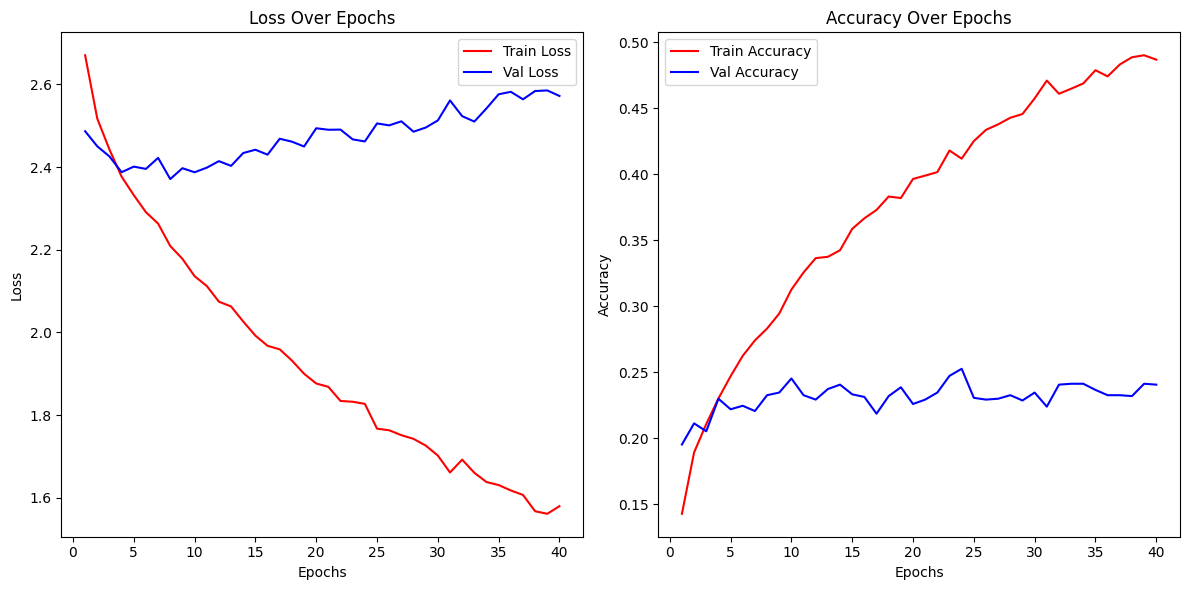

Test Accuracy: 0.2407

Neural Network Classifier Performance:
              precision    recall  f1-score   support

   n01768244       0.33      0.34      0.34       100
   n02074367       0.28      0.37      0.32       100
   n02099712       0.17      0.17      0.17       100
   n02123045       0.20      0.16      0.18       100
   n02123394       0.20      0.16      0.18       100
   n02190166       0.25      0.36      0.29       100
   n02206856       0.15      0.15      0.15       100
   n02226429       0.18      0.17      0.17       100
   n02423022       0.30      0.32      0.31       100
   n02791270       0.25      0.21      0.23       100
   n02917067       0.41      0.46      0.43       100
   n03085013       0.20      0.14      0.16       100
   n03126707       0.23      0.18      0.20       100
   n03179701       0.21      0.21      0.21       100
   n03250847       0.19      0.21      0.20       100

    accuracy                           0.24      1500
   macro avg      

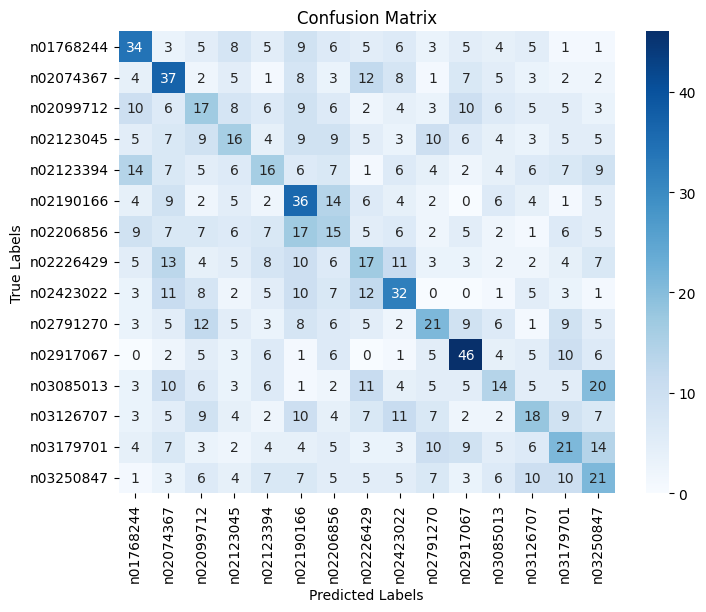

In [9]:
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset directories
train_dir = '/Users/maheshnilewar/Documents/CV_Assignment/train'
test_dir = '/Users/maheshnilewar/Documents/CV_Assignment/test'

# Image transformations
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
train_data = datasets.ImageFolder(root=train_dir, transform=image_transforms)
val_data = datasets.ImageFolder(root=test_dir, transform=image_transforms)

# Class details
categories = train_data.classes
num_categories = len(categories)

# Data Loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Get input size
temp_image, _ = next(iter(train_loader))
_, channels, height, width = temp_image.shape
input_size = height * width * channels  # Flattened size

# Define Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize model, loss, optimizer, and scheduler
model = NeuralNet(input_dim=input_size, hidden_dim=512, output_dim=num_categories).to(device_type)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
epochs = 40
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device_type), lbls.to(device_type)
        imgs = imgs.view(imgs.size(0), -1)  # Flatten
        
        optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_function(preds, lbls)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(preds, 1)
        correct_train += (predicted == lbls).sum().item()
        total_train += lbls.size(0)
    
    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device_type), lbls.to(device_type)
            imgs = imgs.view(imgs.size(0), -1)
            preds = model(imgs)
            loss = loss_function(preds, lbls)
            
            val_loss += loss.item()
            _, predicted = torch.max(preds, 1)
            correct_val += (predicted == lbls).sum().item()
            total_val += lbls.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_accuracy)
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

# Save the model
torch.save(model.state_dict(), "neural_net.pth")
print("Model saved successfully!")


# Plot loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_history, label='Train Loss', color='red')
plt.plot(range(1, epochs + 1), val_loss_history, label='Val Loss', color='blue')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc_history, label='Train Accuracy', color='red')
plt.plot(range(1, epochs + 1), val_acc_history, label='Val Accuracy', color='blue')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation
predictions_list, labels_list = [], []
with torch.no_grad():
    correct, total = 0, 0
    for imgs, lbls in val_loader:
        imgs, lbls = imgs.to(device_type), lbls.to(device_type)
        imgs = imgs.view(imgs.size(0), -1)
        preds = model(imgs)
        _, predicted_lbls = torch.max(preds, 1)
        predictions_list.extend(predicted_lbls.cpu().numpy())
        labels_list.extend(lbls.cpu().numpy())
        correct += (predicted_lbls == lbls).sum().item()
        total += lbls.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Report
print("\nNeural Network Classifier Performance:")
print(classification_report(labels_list, predictions_list, target_names=categories))

# Confusion Matrix
conf_matrix = confusion_matrix(labels_list, predictions_list)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Epoch 1/40 | Train Loss: 2.6868 | Train Acc: 0.1380 | Val Loss: 2.5062 | Val Acc: 0.1807
Epoch 2/40 | Train Loss: 2.5637 | Train Acc: 0.1677 | Val Loss: 2.4936 | Val Acc: 0.1960
Epoch 3/40 | Train Loss: 2.5062 | Train Acc: 0.1885 | Val Loss: 2.4363 | Val Acc: 0.2220
Epoch 4/40 | Train Loss: 2.4751 | Train Acc: 0.1945 | Val Loss: 2.4410 | Val Acc: 0.2193
Epoch 5/40 | Train Loss: 2.4500 | Train Acc: 0.2065 | Val Loss: 2.4270 | Val Acc: 0.2140
Epoch 6/40 | Train Loss: 2.4285 | Train Acc: 0.2077 | Val Loss: 2.4204 | Val Acc: 0.2187
Epoch 7/40 | Train Loss: 2.4191 | Train Acc: 0.2155 | Val Loss: 2.4024 | Val Acc: 0.2220
Epoch 8/40 | Train Loss: 2.4219 | Train Acc: 0.2115 | Val Loss: 2.4069 | Val Acc: 0.2287
Epoch 9/40 | Train Loss: 2.4109 | Train Acc: 0.2093 | Val Loss: 2.4031 | Val Acc: 0.2287
Epoch 10/40 | Train Loss: 2.3984 | Train Acc: 0.2178 | Val Loss: 2.3819 | Val Acc: 0.2440
Epoch 11/40 | Train Loss: 2.3834 | Train Acc: 0.2263 | Val Loss: 2.3733 | Val Acc: 0.2333
Epoch 12/40 | Train

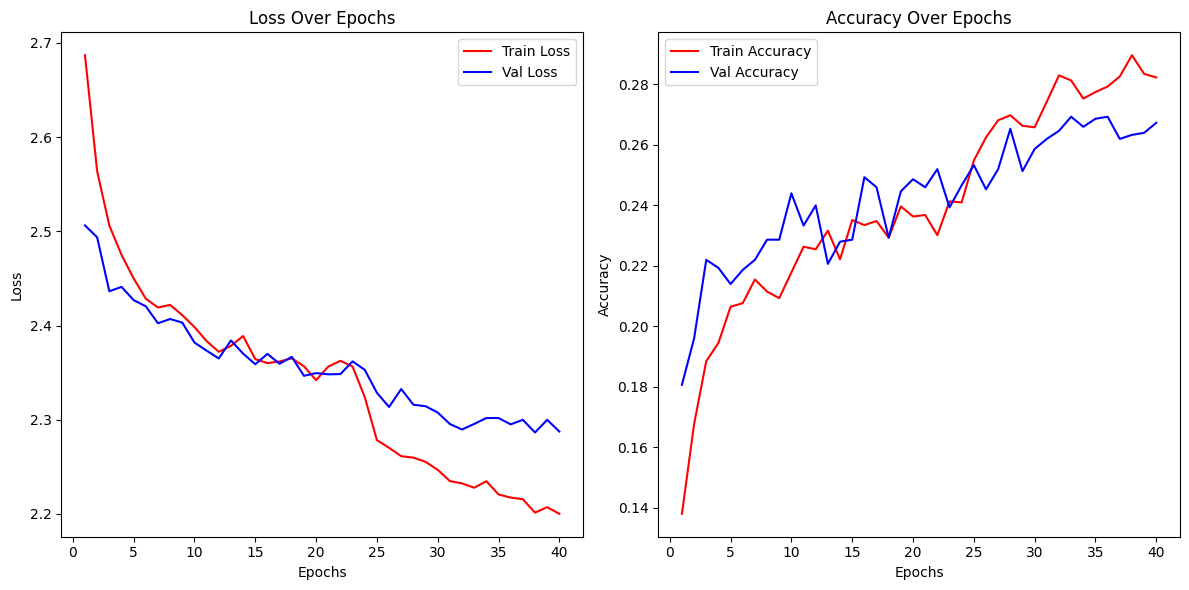

Test Accuracy: 0.2673

Neural Network Classifier Performance:
              precision    recall  f1-score   support

   n01768244       0.33      0.35      0.34       100
   n02074367       0.28      0.33      0.30       100
   n02099712       0.22      0.13      0.16       100
   n02123045       0.23      0.23      0.23       100
   n02123394       0.16      0.13      0.14       100
   n02190166       0.36      0.37      0.36       100
   n02206856       0.18      0.12      0.14       100
   n02226429       0.17      0.23      0.20       100
   n02423022       0.32      0.45      0.37       100
   n02791270       0.18      0.18      0.18       100
   n02917067       0.38      0.57      0.45       100
   n03085013       0.27      0.20      0.23       100
   n03126707       0.34      0.29      0.31       100
   n03179701       0.23      0.23      0.23       100
   n03250847       0.29      0.20      0.24       100

    accuracy                           0.27      1500
   macro avg      

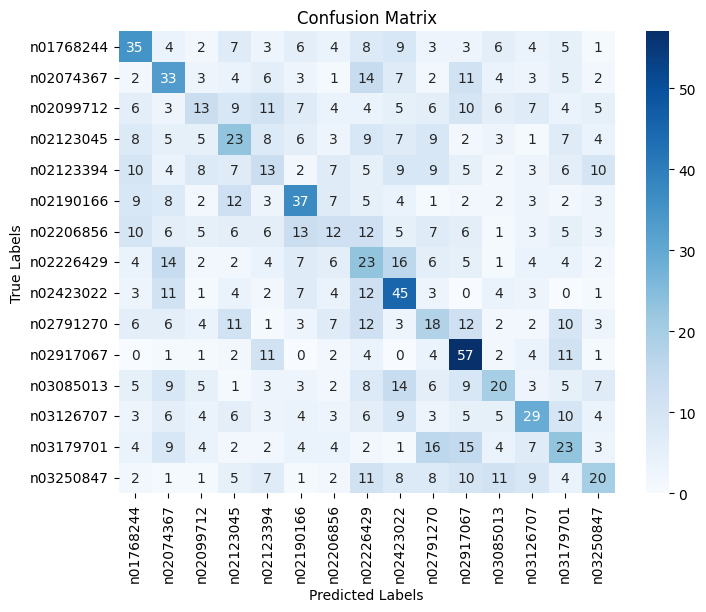

In [14]:
# Device
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset directories
train_dir = '/Users/maheshnilewar/Documents/CV_Assignment/train'
test_dir = '/Users/maheshnilewar/Documents/CV_Assignment/test'

# Image transformations with data augmentation
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation
    transforms.RandomCrop(128, padding=4),  # Random cropping with padding
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization
])

# Load dataset
train_data = datasets.ImageFolder(root=train_dir, transform=image_transforms)
val_data = datasets.ImageFolder(root=test_dir, transform=image_transforms)

# Class details
categories = train_data.classes
num_categories = len(categories)

# Data Loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Get input size
temp_image, _ = next(iter(train_loader))
_, channels, height, width = temp_image.shape
input_size = height * width * channels  # Flattened size

# Define Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize model, loss, optimizer, and scheduler
model = NeuralNet(input_dim=input_size, hidden_dim=512, output_dim=num_categories).to(device_type)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# Training loop
epochs = 40
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device_type), lbls.to(device_type)
        imgs = imgs.view(imgs.size(0), -1)  # Flatten
        
        optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_function(preds, lbls)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(preds, 1)
        correct_train += (predicted == lbls).sum().item()
        total_train += lbls.size(0)
    
    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device_type), lbls.to(device_type)
            imgs = imgs.view(imgs.size(0), -1)
            preds = model(imgs)
            loss = loss_function(preds, lbls)
            
            val_loss += loss.item()
            _, predicted = torch.max(preds, 1)
            correct_val += (predicted == lbls).sum().item()
            total_val += lbls.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val

    # Update learning rate based on validation loss
    lr_scheduler.step(val_loss)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_accuracy)
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

# Save the model
torch.save(model.state_dict(), "neural_net.pth")
print("Model saved successfully!")

# Plot loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_history, label='Train Loss', color='red')
plt.plot(range(1, epochs + 1), val_loss_history, label='Val Loss', color='blue')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc_history, label='Train Accuracy', color='red')
plt.plot(range(1, epochs + 1), val_acc_history, label='Val Accuracy', color='blue')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation
predictions_list, labels_list = [], []
with torch.no_grad():
    correct, total = 0, 0
    for imgs, lbls in val_loader:
        imgs, lbls = imgs.to(device_type), lbls.to(device_type)
        imgs = imgs.view(imgs.size(0), -1)
        preds = model(imgs)
        _, predicted_lbls = torch.max(preds, 1)
        predictions_list.extend(predicted_lbls.cpu().numpy())
        labels_list.extend(lbls.cpu().numpy())
        correct += (predicted_lbls == lbls).sum().item()
        total += lbls.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Report
print("\nNeural Network Classifier Performance:")
print(classification_report(labels_list, predictions_list, target_names=categories))

# Confusion Matrix
conf_matrix = confusion_matrix(labels_list, predictions_list)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
